<a href="https://colab.research.google.com/github/kraftpunk97/FashionMNIST-with-keras/blob/master/Fashion_MNIST_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST classification using Keras

<p>This notebook is a result of my experimentation with keras, which is something I've been wanting to try for a long time. I don't really like TensorFlow because I feel its way of doing things is way too convoluted. [keras](https://keras.io) is an API that sits on top of TensorFlow and uses a relatively easy-to-understand syntax, so that we don't have to deal with the guts of TensorFlow; keras takes care of it for us.</p><br>

<p>In this notebook, we will be tackling the Fashion MNIST dataset. We will be training three increasingly complex CNNs and then we populate our dataset using data augmentation techniques and further train the three models on the augmented dataset.</p><br>

We start off by importing our requirerd libraries. They are `tensorflow.keras` for the nerual network, `numpy` for linear algebra and `matplotlib.pyplot` for drawing pretty pictures...

In [1]:
import tensorflow as tf
from tensorflow import keras


import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.15.0


We download our dataset which can be done easily, thanks to `keras`. We further proceed to divide this dataset into training data and testing data.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Each unique label value refers to a particular type of clothing item. We assign each type to that value...

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

num_classes = len(class_names)

Further dividing the original training data into actual training data (80%) and  cross validation data (20%)...

In [4]:
def gen_train_validation(train_images, train_labels, size=0.8):
  train_idx = np.random.choice(len(train_images), np.int(np.floor(size*len(train_images))), replace=False)
  cv_idx = [i for i in range(len(train_images)) if i not in train_idx]
  train_images_, train_labels_ = train_images[train_idx], train_labels[train_idx]
  cv_images, cv_labels = train_images[cv_idx], train_labels[cv_idx]
  return train_images_, train_labels_, cv_images, cv_labels


train_images, train_labels, cv_images, cv_labels = gen_train_validation(train_images, train_labels)

print("Shape of training images : {}".format(train_images.shape))
print("Shape of Cross Validation images : {}".format(cv_images.shape))
print("Shape of testing images : {}".format(test_images.shape))

Shape of training images : (48000, 28, 28)
Shape of Cross Validation images : (12000, 28, 28)
Shape of testing images : (10000, 28, 28)


In [5]:
_, image_rows, image_cols = train_images.shape
input_shape = (image_rows, image_cols, 1)

print(input_shape)

(28, 28, 1)


Visualising a sample image...

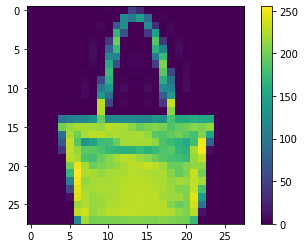

Bag


In [6]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()
print(class_names[train_labels[0]])

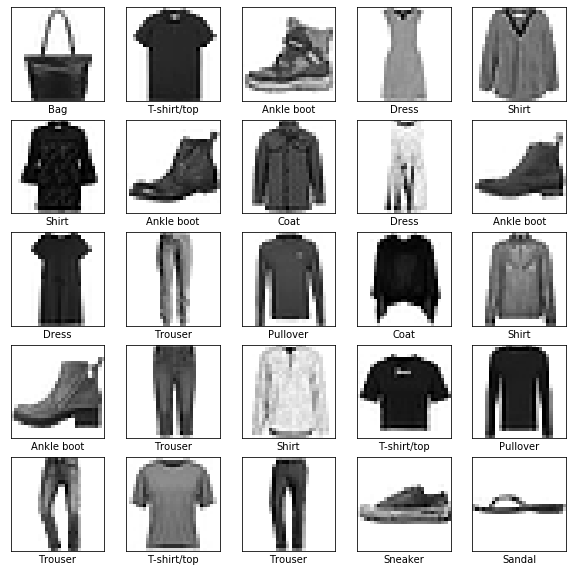

In [7]:
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i]])
plt.show()

Preprocessing the images by appending an extra dimension to the images, because that is something that keras requires us to do...

In [8]:
def preprocess(images):
  return images.reshape((len(images), image_rows, image_cols, 1))

train_images = preprocess(train_images)
cv_images = preprocess(cv_images)
test_images = preprocess(test_images)

print("Shape of training images : {}".format(train_images.shape))
print("Shape of Cross Validation images : {}".format(cv_images.shape))
print("Shape of testing images : {}".format(test_images.shape))

Shape of training images : (48000, 28, 28, 1)
Shape of Cross Validation images : (12000, 28, 28, 1)
Shape of testing images : (10000, 28, 28, 1)


Scaling the values of the individual pixels from 0->255 to 0->1 for reduced computational complexity..

In [0]:
train_images = train_images.astype('float32') / 255
cv_images = cv_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

## Utilites

In this section, we define a few utilites that will help us better understand our model and the results of the training process.

In [0]:
# Prints the summary of the neural network and its constituent layers...
def print_summary(section):
  print("\n\n\n{} summary--".format(section.name))
  section.summary()

# Plots the results of training process. We plot two graphs in which we compare
# the training and CV loss and training and CV accuracy
def plot_progress(history_cnn):
  acc = history_cnn.history['acc']
  val_acc = history_cnn.history['val_acc']
  loss = history_cnn.history['loss']
  val_loss = history_cnn.history['val_loss']
  
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, "r", label="Training accuracy")
  plt.plot(epochs, val_acc, "b", label="Validation accuracy")
  plt.legend()
  plt.figure()
  
  plt.plot(epochs, loss, "r", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.legend()
  plt.show()

  
# This helper function will help us see the variation in a metric across various
# models...
def plot_metric_across_models(histories, metric, colors):
  metric_collection = [history.history[metric] for history in histories]
  
  epochs = range(len(metric_collection[0]))
  
  for history, metric_arr, color in zip(histories, metric_collection, colors):
    plt.plot(epochs, metric_arr, color, label=history.model.name)
  
  plt.xlabel("#epochs")
  plt.ylabel(metric)
  plt.legend()
  plt.show()

## Hyperparameters

We use this opportunity to define our hyperparameters. Each model will be trained for 100 epochs and in batches of 256.

In [0]:
epochs = 20
batch_size = 256

## 1-Conv CNN (`model_cnn1`)

We describe a model that contains only one Convolution layer. We will use the ReLU activation function and use Maxpooling to summarise the patches of the feature maps and to downsample the features. We use the DropOut method to regularize our model. Following is a brief summary of the model...

(`conv_layer11`)\[ Conv ---> MaxPool ----> DropOut] ----><br>
Unroll ----><br>
(`dense_layer11`)\[ Dense -----> Dense ]

In [12]:
conv_layer11 = keras.Sequential([
    # Convolutional layers
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2)
], name="conv_layer11")


dense_layer11 = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(num_classes, activation=tf.nn.softmax)
], name="dense_layer11")

model_cnn1 = keras.Sequential([
    # Convolutional layers
    conv_layer11,
    # Unrolling...
    keras.layers.Flatten(),
    
    # Feeding the unrolled vector to the FC layers...
    dense_layer11
], name="model_cnn1")

print_summary(conv_layer11)
print_summary(dense_layer11)
print_summary(model_cnn1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



conv_layer11 summary--
Model: "conv_layer11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________



dense_layer11 summary--
Model: "dense_layer11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               692352    
_______________________________

We'll be using the ADAM optimizer to reduce the loss of the model. The calculated loss is the crossentropy loss; `sparse_categorical_crossentropy` loss to be exact. We use this loss as opposed to your `categorical_crossentropy` loss because our targets are integers. Had our targets been one-hot encoded vectors, we would have used `categorical_crossentropy`.

In [13]:
model_cnn1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history_cnn1 = model_cnn1.fit(train_images, train_labels, epochs=epochs, 
                              validation_data=(cv_images, cv_labels), batch_size=batch_size)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 7s 145us/sample - loss: 0.5342 - acc: 0.8140 - val_loss: 0.3758 - val_acc: 0.8707
Epoch 2/20
48000/48000 [==============================] - 1s 18us/sample - loss: 0.3519 - acc: 0.8767 - val_loss: 0.3283 - val_acc: 0.8842
Epoch 3/20
48000/48000 [==============================] - 1s 18us/sample - loss: 0.3071 - acc: 0.8905 - val_loss: 0.3037 - val_acc: 0.8925
Epoch 4/20
48000/48000 [==============================] - 1s 19us/sample - loss: 0.2810 - acc: 0.8995 - val_loss: 0.2841 - val_acc: 0.8996
Epoch 5/20
48000/48000 [==============================] - 1s 18us/sample - loss: 0.2570 - acc: 0.9084 - val_loss: 0.2756 - val_acc: 0.9016
Epoch 6/20
48000/48000 [==============================] - 1s 19us/sample - loss: 0.2408 - acc: 0.9127 - val_loss: 0.2805 - val_acc: 0.8971
Epoch 7/20
48000/48000 [==============================] - 1s 18us/sample - loss: 0.2264 - acc: 0.9187 - val_loss: 0

In [14]:
cv_loss, cv_acc = model_cnn1.evaluate(cv_images, cv_labels)
train_loss, train_acc = model_cnn1.evaluate(train_images, train_labels)

print("Training loss", train_loss)
print("Cross Validation loss: ", cv_loss)
print("Training accuracy", train_acc)
print("Cross Validation accuracy: ", cv_acc)

48000/48000 [==============================] - 2s 43us/sample - loss: 0.0797 - acc: 0.9740
Training loss 0.07967571246779213
Cross Validation loss:  0.24569589676335454
Training accuracy 0.97404164
Cross Validation accuracy:  0.91933334


After 20 epochs of training, our model achieves 94.6% accuracy on the training images and 92.1% accuracy on the Cross-validation set. 

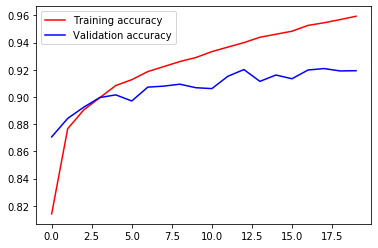

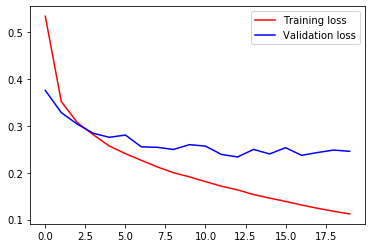

In [15]:
plot_progress(history_cnn1)

Next we try a different model and see if we achieve different results...



## 3-Conv CNN (`model_cnn2`)

In this model, we'll be using three Convolution layers. The sequence is...

(`conv_layer21`)\[ Conv ---> MaxPool ---> DropOut] ---><br>
(`conv_layer22`)\[ Conv ---> MaxPool ---> DropOut] ---><br>
(`conv_layer23`)\[ Conv ---> DropOut] ---><br>
Unroll ---><br>
(`dense_layer21`)\[ Dense ----> DropOut ] ---><br>
(`dense_layer22`)\[ Dense ]

In [16]:
conv_layer21 = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25)
], name="conv_layer21")

conv_layer22 = keras.Sequential([
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25)
], name="conv_layer22")

conv_layer23 = keras.Sequential([
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.Dropout(0.4)
], name="conv_layer23")

dense_layer21 = keras.Sequential([
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.3)
], name="dense_layer21")

dense_layer22 = keras.Sequential([
    keras.layers.Dense(10, activation="softmax")  
], name="dense_layer22")

model_cnn2 = keras.Sequential([
    # Conv layers...
    conv_layer21,
    conv_layer22,
    conv_layer23,
    
    # Unrolling...
    keras.layers.Flatten(),
    
    # Dense layer
    dense_layer21,
    dense_layer22
], name="model_cnn2")

print_summary(conv_layer21)
print_summary(conv_layer22)
print_summary(conv_layer23)
print_summary(dense_layer21)
print_summary(dense_layer22)
print_summary(model_cnn2)




conv_layer21 summary--
Model: "conv_layer21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________



conv_layer22 summary--
Model: "conv_layer22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)   

In [17]:
model_cnn2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_cnn2 = model_cnn2.fit(train_images, train_labels, epochs=epochs, 
                              validation_data=(cv_images, cv_labels), batch_size=batch_size)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 2s 32us/sample - loss: 0.8841 - acc: 0.6701 - val_loss: 0.5394 - val_acc: 0.8001
Epoch 2/20
48000/48000 [==============================] - 1s 26us/sample - loss: 0.5427 - acc: 0.7982 - val_loss: 0.4507 - val_acc: 0.8359
Epoch 3/20
48000/48000 [==============================] - 1s 26us/sample - loss: 0.4661 - acc: 0.8291 - val_loss: 0.3852 - val_acc: 0.8612
Epoch 4/20
48000/48000 [==============================] - 1s 26us/sample - loss: 0.4171 - acc: 0.8471 - val_loss: 0.3454 - val_acc: 0.8728
Epoch 5/20
48000/48000 [==============================] - 1s 26us/sample - loss: 0.3817 - acc: 0.8604 - val_loss: 0.3203 - val_acc: 0.8852
Epoch 6/20
48000/48000 [==============================] - 1s 26us/sample - loss: 0.3646 - acc: 0.8673 - val_loss: 0.3074 - val_acc: 0.8859
Epoch 7/20
48000/48000 [==============================] - 1s 26us/sample - loss: 0.3502 - acc: 0.8718 - val_loss: 0.

In [18]:
cv_loss, cv_acc = model_cnn2.evaluate(cv_images, cv_labels)
train_loss, train_acc = model_cnn2.evaluate(train_images, train_labels)

print("Training loss", train_loss)
print("Cross Validation loss: ", cv_loss)
print("Training accuracy", train_acc)
print("Cross Validation accuracy: ", cv_acc)

48000/48000 [==============================] - 2s 49us/sample - loss: 0.1873 - acc: 0.9304
Training loss 0.1873068146929145
Cross Validation loss:  0.23589739367862542
Training accuracy 0.93041664
Cross Validation accuracy:  0.9130833


We get a 91.7% accuracy on the training set and 90.6 accuracy on the CV set. CV accuracy seems to have gone down from the last model. I wonder why...🧐 Loss is looking good though...

**UPDATE** - The reason is the number of trainable parameters in `model_cnn2`. Here we have 241,546 trainable parameters. In contrast, `model_cnn1` has 693,962 trainable parameters and `model_cnn3` has a whopping 4,947,530 trainable parameters. This is why `model_cnn1` outperforms `model_cnn2` and is in turn, itself outperformed by `model_cnn3`.

The number of ConvLayers increased from `model_cnn1` to `model_cnn2`, but the number of trainable paramenters went down. Why? Dropout. We have made liberal use of Dropout Regularization in `model_cnn2`. This is why the number of trainable parameters went down, despite the increase in the number of layers. As a rule of thumb, do not apply Dropout **after every** layer.

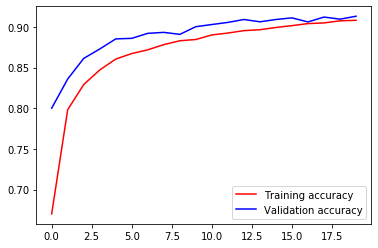

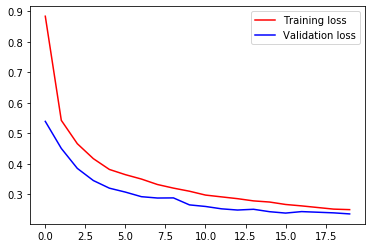

In [19]:
plot_progress(history_cnn2)

## 4-Conv CNN (`model_cnn3`)

This time we use a 4 convolutional layers. I summarise the model below... <br><br>

(`conv_layer31`)\[Conv --> BatchNorm] --> <br>
(`conv_layer32`)\[Conv --> BatchNorm --> MaxPool --> DropOut] => <br>
(`conv_layer33`)\[Conv --> BatchNorm --> Dropout] ---> <br> (`conv_layer34`)\[Conv --> BatchNorm --> MaxPool --> DropOut]  => <br>
Unroll --> <br>
(`dense_layer31`)\[Dense --> BatchNorm --> DropOut] --> <br>(`dense_layer32`)\[Dense --> BatcNorm --> DropOut] --> <br>(`dense_layer33`)\[Dense]

In [20]:
conv_layer31 = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    keras.layers.BatchNormalization()
], name="conv_layer31")

conv_layer32 = keras.Sequential([
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25)
], name="conv_layer32")

conv_layer33 = keras.Sequential([
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25)
], name="conv_layer33")

conv_layer34 = keras.Sequential([
    keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25)
], name="conv_layer34")

dense_layer31 = keras.Sequential([
    keras.layers.Dense(512, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5)
], name="dense_layer31")

dense_layer32 = keras.Sequential([
    keras.layers.Dense(128, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5)
], name="dense_layer32")

dense_layer33 = keras.Sequential([
    keras.layers.Dense(num_classes, activation="softmax")
], name="dense_layer33")


# Bringing everything together...
model_cnn3 = keras.Sequential([
    
    # Conv layers
    conv_layer31,
    conv_layer32,
    conv_layer33,
    conv_layer34,
    
    # Unrolling...
    keras.layers.Flatten(),
    
    # Dense layers
    dense_layer31,
    dense_layer32,
    dense_layer33
], name="model_cnn3")

print_summary(conv_layer31)
print_summary(conv_layer32)
print_summary(conv_layer33)
print_summary(conv_layer34)
print_summary(dense_layer31)
print_summary(dense_layer32)
print_summary(dense_layer33)
print_summary(model_cnn3)




conv_layer31 summary--
Model: "conv_layer31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
Total params: 448
Trainable params: 384
Non-trainable params: 64
_________________________________________________________________



conv_layer32 summary--
Model: "conv_layer32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)

In [21]:
model_cnn3.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_cnn3 = model_cnn3.fit(train_images, train_labels, epochs=epochs, 
                              validation_data=(cv_images, cv_labels), batch_size=batch_size)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 6s 123us/sample - loss: 0.6434 - acc: 0.7797 - val_loss: 4.0067 - val_acc: 0.0983
Epoch 2/20
48000/48000 [==============================] - 5s 103us/sample - loss: 0.3728 - acc: 0.8682 - val_loss: 2.9027 - val_acc: 0.3058
Epoch 3/20
48000/48000 [==============================] - 5s 103us/sample - loss: 0.3102 - acc: 0.8900 - val_loss: 0.4431 - val_acc: 0.8429
Epoch 4/20
48000/48000 [==============================] - 5s 104us/sample - loss: 0.2770 - acc: 0.9028 - val_loss: 0.2414 - val_acc: 0.9133
Epoch 5/20
48000/48000 [==============================] - 5s 104us/sample - loss: 0.2530 - acc: 0.9107 - val_loss: 0.2304 - val_acc: 0.9159
Epoch 6/20
48000/48000 [==============================] - 5s 104us/sample - loss: 0.2349 - acc: 0.9172 - val_loss: 0.2373 - val_acc: 0.9167
Epoch 7/20
48000/48000 [==============================] - 5s 104us/sample - loss: 0.2154 - acc: 0.9246 - val_l

In [22]:
cv_loss, cv_acc = model_cnn3.evaluate(cv_images, cv_labels)
train_loss, train_acc = model_cnn3.evaluate(train_images, train_labels)

print("Training loss", train_loss)
print("Cross Validation loss: ", cv_loss)
print("Training accuracy", train_acc)
print("Cross Validation accuracy: ", cv_acc)

48000/48000 [==============================] - 4s 81us/sample - loss: 0.0405 - acc: 0.9879
Training loss 0.04047066290470927
Cross Validation loss:  0.21303893176838756
Training accuracy 0.987875
Cross Validation accuracy:  0.9356667


Okay, so after 20 iterations our training accuracy is now a whopping 97% and CV accuracy is at a 94%. Looking at the loss graph below, it seems that the loss had started to increase in the last few epochs.

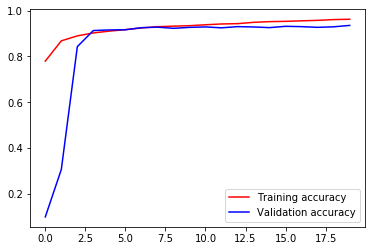

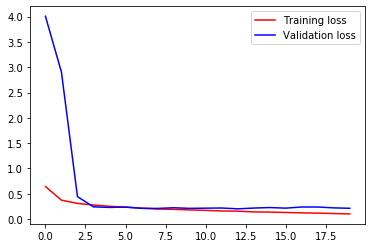

In [23]:
plot_progress(history_cnn3)

We next plot each of the 4 metrics - Training loss, training accuracy, CV loss, CV accuracy for all three models and try to discover any underlying trends. There is nothing out of the oridinary here, except for the fact that `model_cnn2` seems to perform poorly on the training set for some reason. I wonder why...🧐

**UPDATE** - The reason is the number of trainable parameters in `model_cnn2`. Here we have 241,546 trainable parameters. In contrast, `model_cnn1` has 693,962 trainable parameters and `model_cnn3` has a whopping 4,947,530 trainable parameters. This is why `model_cnn1` outperforms `model_cnn2` and is in turn, itself outperformed by `model_cnn3`.

The number of ConvLayers increased from `model_cnn1` to `model_cnn2`, but the number of trainable paramenters went down. Why? Dropout. We have made liberal use of Dropout Regularization in `model_cnn2`. This is why the number of trainable parameters went down, despite the increase in the number of layers. As a rule of thumb, do not apply Dropout **after every** layer.

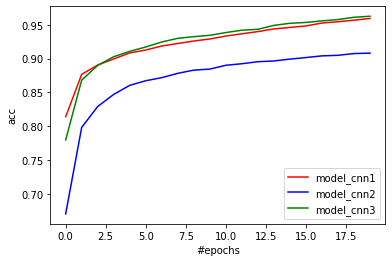

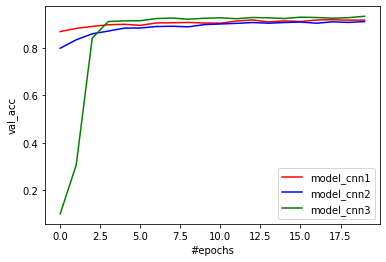

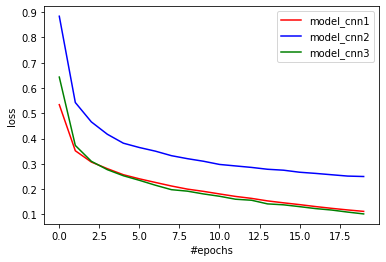

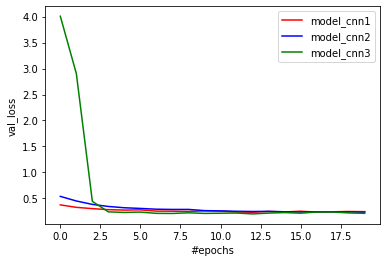

In [24]:
plot_metric_across_models((history_cnn1, history_cnn2, history_cnn3), 'acc', ('r', 'b', 'g'))
plot_metric_across_models((history_cnn1, history_cnn2, history_cnn3), 'val_acc', ('r', 'b', 'g'))
plot_metric_across_models((history_cnn1, history_cnn2, history_cnn3), 'loss', ('r', 'b', 'g'))
plot_metric_across_models((history_cnn1, history_cnn2, history_cnn3), 'val_loss', ('r', 'b', 'g'))

## Data Augmentation

We now perform a series a data augmentations. Data Augmentation is a collection of crafty techniques that can be used to populate our training data. This is helpful if we have a modest dataset to work with. Simple models work well with a lot of training data. Since our models **are** simple, this is something we can use in this situation.

In [25]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                              height_shift_range=0.08, zoom_range=0.08)

train_batches = generator.flow(train_images, train_labels, batch_size=256)
val_batches = generator.flow(cv_images, cv_labels, batch_size=256)

Using TensorFlow backend.


We now proceed to further train our models on this new data. This should definitely improve our models, make them more robust.

In [26]:
history_cnn12 = model_cnn1.fit_generator(train_batches, epochs=50, 
                                         validation_data=val_batches, use_multiprocessing=True)

Epoch 1/50
188/188 [==============================] - 14s 73ms/step - loss: 0.4428 - acc: 0.8366 - val_loss: 0.4038 - val_acc: 0.8490
Epoch 2/50
188/188 [==============================] - 13s 69ms/step - loss: 0.3777 - acc: 0.8586 - val_loss: 0.3723 - val_acc: 0.8607
Epoch 3/50
188/188 [==============================] - 13s 69ms/step - loss: 0.3643 - acc: 0.8627 - val_loss: 0.3550 - val_acc: 0.8709
Epoch 4/50
188/188 [==============================] - 13s 70ms/step - loss: 0.3474 - acc: 0.8705 - val_loss: 0.3428 - val_acc: 0.8733
Epoch 5/50
188/188 [==============================] - 13s 70ms/step - loss: 0.3389 - acc: 0.8725 - val_loss: 0.3415 - val_acc: 0.8742
Epoch 6/50
188/188 [==============================] - 13s 70ms/step - loss: 0.3260 - acc: 0.8776 - val_loss: 0.3402 - val_acc: 0.8736
Epoch 7/50
188/188 [==============================] - 13s 70ms/step - loss: 0.3212 - acc: 0.8811 - val_loss: 0.3284 - val_acc: 0.8776
Epoch 8/50
188/188 [==============================] - 13s 69ms

In [27]:
history_cnn22 = model_cnn2.fit_generator(train_batches, epochs=50, 
                                         validation_data=val_batches, use_multiprocessing=True)

Epoch 1/50
188/188 [==============================] - 14s 75ms/step - loss: 0.4464 - acc: 0.8317 - val_loss: 0.3576 - val_acc: 0.8641
Epoch 2/50
188/188 [==============================] - 13s 70ms/step - loss: 0.4079 - acc: 0.8454 - val_loss: 0.3379 - val_acc: 0.8753
Epoch 3/50
188/188 [==============================] - 13s 70ms/step - loss: 0.3910 - acc: 0.8536 - val_loss: 0.3270 - val_acc: 0.8759
Epoch 4/50
188/188 [==============================] - 14s 73ms/step - loss: 0.3840 - acc: 0.8575 - val_loss: 0.3230 - val_acc: 0.8787
Epoch 5/50
188/188 [==============================] - 13s 70ms/step - loss: 0.3735 - acc: 0.8599 - val_loss: 0.3149 - val_acc: 0.8819
Epoch 6/50
188/188 [==============================] - 13s 70ms/step - loss: 0.3738 - acc: 0.8603 - val_loss: 0.3230 - val_acc: 0.8783
Epoch 7/50
188/188 [==============================] - 13s 70ms/step - loss: 0.3640 - acc: 0.8658 - val_loss: 0.3077 - val_acc: 0.8864
Epoch 8/50
188/188 [==============================] - 13s 70ms

In [28]:
history_cnn32 = model_cnn3.fit_generator(train_batches, epochs=50, 
                                         validation_data=val_batches, use_multiprocessing=True)

Epoch 1/50
188/188 [==============================] - 16s 85ms/step - loss: 0.3458 - acc: 0.8788 - val_loss: 0.2740 - val_acc: 0.9006
Epoch 2/50
188/188 [==============================] - 15s 80ms/step - loss: 0.2871 - acc: 0.8968 - val_loss: 0.2832 - val_acc: 0.8970
Epoch 3/50
188/188 [==============================] - 15s 80ms/step - loss: 0.2722 - acc: 0.9025 - val_loss: 0.2770 - val_acc: 0.9012
Epoch 4/50
188/188 [==============================] - 15s 79ms/step - loss: 0.2606 - acc: 0.9072 - val_loss: 0.2494 - val_acc: 0.9078
Epoch 5/50
188/188 [==============================] - 15s 79ms/step - loss: 0.2535 - acc: 0.9090 - val_loss: 0.2439 - val_acc: 0.9119
Epoch 6/50
188/188 [==============================] - 15s 79ms/step - loss: 0.2486 - acc: 0.9111 - val_loss: 0.2438 - val_acc: 0.9133
Epoch 7/50
188/188 [==============================] - 15s 79ms/step - loss: 0.2422 - acc: 0.9135 - val_loss: 0.2327 - val_acc: 0.9155
Epoch 8/50
188/188 [==============================] - 15s 79ms

47/47 [==============================] - 3s 54ms/step - loss: 0.2635 - acc: 0.9020
Training loss 0.26352363032229403
Cross Validation loss:  0.21295806892374727
Training accuracy 0.902
Cross Validation accuracy:  0.9211042


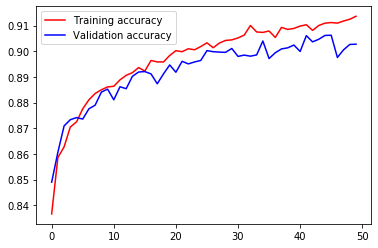

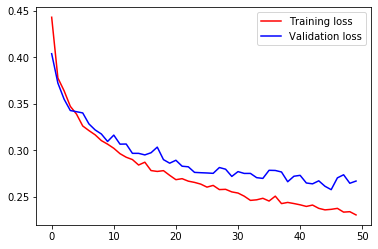

In [29]:
cv_loss, cv_acc = model_cnn1.evaluate(train_batches)
train_loss, train_acc = model_cnn1.evaluate(val_batches)

print("Training loss", train_loss)
print("Cross Validation loss: ", cv_loss)
print("Training accuracy", train_acc)
print("Cross Validation accuracy: ", cv_acc)
plot_progress(history_cnn12)

Nothing interesting here, except for the increase in the training loss (0.1419 ----> 0.259). Accuracy is somewhat similar to what we saw earlier.

47/47 [==============================] - 3s 55ms/step - loss: 0.2500 - acc: 0.9067
Training loss 0.25000984966754913
Cross Validation loss:  0.22752752575151464
Training accuracy 0.9066667
Cross Validation accuracy:  0.91489583


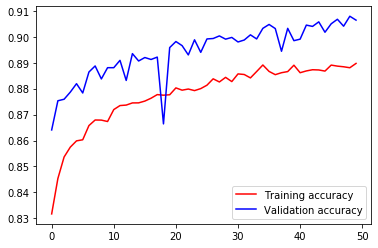

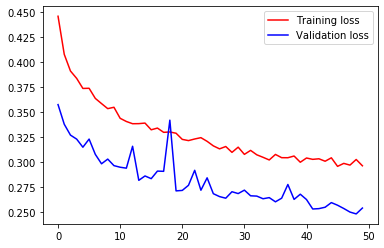

In [30]:
cv_loss, cv_acc = model_cnn2.evaluate(train_batches)
train_loss, train_acc = model_cnn2.evaluate(val_batches)

print("Training loss", train_loss)
print("Cross Validation loss: ", cv_loss)
print("Training accuracy", train_acc)
print("Cross Validation accuracy: ", cv_acc)
plot_progress(history_cnn22)

Loss went down and accuracy went up. Data augmentation seems to have somewhat improvevd `model_cnn2`.

47/47 [==============================] - 3s 57ms/step - loss: 0.2004 - acc: 0.9337
Training loss 0.20035672948715536
Cross Validation loss:  0.10228566870965222
Training accuracy 0.93366665
Cross Validation accuracy:  0.9628958


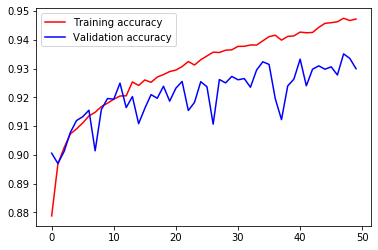

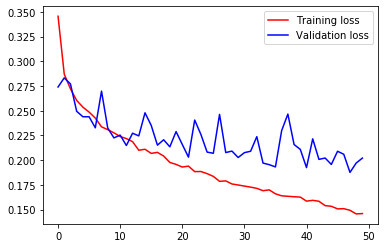

In [31]:
cv_loss, cv_acc = model_cnn3.evaluate(train_batches)
train_loss, train_acc = model_cnn3.evaluate(val_batches)

print("Training loss", train_loss)
print("Cross Validation loss: ", cv_loss)
print("Training accuracy", train_acc)
print("Cross Validation accuracy: ", cv_acc)
plot_progress(history_cnn32)

Training loss and accuracy went somewhat down, but there's also an increase in CV metrics for `model_cnn3`.

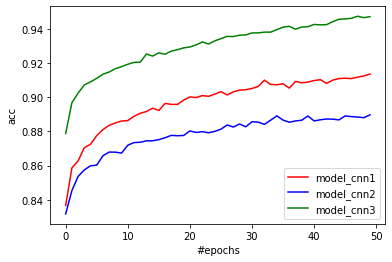

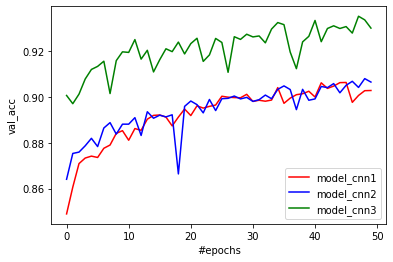

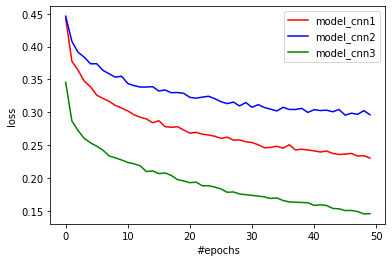

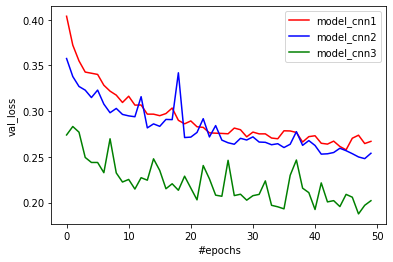

In [32]:
plot_metric_across_models((history_cnn12, history_cnn22, history_cnn32), 'acc', ('r', 'b', 'g'))
plot_metric_across_models((history_cnn12, history_cnn22, history_cnn32), 'val_acc', ('r', 'b', 'g'))
plot_metric_across_models((history_cnn12, history_cnn22, history_cnn32), 'loss', ('r', 'b', 'g'))
plot_metric_across_models((history_cnn12, history_cnn22, history_cnn32), 'val_loss', ('r', 'b', 'g'))

Looking at this data, `model_cnn3` seems to do exceptionally well than than `model_cnn2` and `model_cnn1` on augmented data. Once again, `model_cnn2` performs worst on training data. I cannot understand why.

## Performance on the test set

In [33]:
test_loss, test_acc = model_cnn1.evaluate(test_images, test_labels)

print("For model_cnn1...")
print("Test loss", test_loss)
print("Test accuracy: ", test_acc)
print("\n")

test_loss, test_acc = model_cnn2.evaluate(test_images, test_labels)

print("For model_cnn2...")
print("Test loss", test_loss)
print("Test accuracy: ", test_acc)
print("\n")

test_loss, test_acc = model_cnn3.evaluate(test_images, test_labels)

print("For model_cnn3...")
print("Test loss", test_loss)
print("Test accuracy: ", test_acc)
print("\n")

10000/10000 [==============================] - 0s 47us/sample - loss: 0.2535 - acc: 0.9162
For model_cnn1...
Test loss 0.253516530841589
Test accuracy:  0.9162


10000/10000 [==============================] - 1s 53us/sample - loss: 0.2510 - acc: 0.9025
For model_cnn2...
Test loss 0.2509802815198898
Test accuracy:  0.9025


10000/10000 [==============================] - 1s 82us/sample - loss: 0.2085 - acc: 0.9308
For model_cnn3...
Test loss 0.2084840574681759
Test accuracy:  0.9308




The results speak for themselves; `model_cnn3` performs best.

## Saving the model

In [0]:
from keras.models import model_from_json

def save_model(model):
  model_json = model.to_json()
  with open(model.name+".json", "w") as json_file:
    json_file.write(model_json)
  model.save_weights(model.name+".h5")
  print(model.name + " has been saved to disk")

In [35]:
save_model(model_cnn1)
save_model(model_cnn2)
save_model(model_cnn3)

model_cnn1 has been saved to disk
model_cnn2 has been saved to disk
model_cnn3 has been saved to disk


In [39]:
save_model(model_cnn1)

model_cnn1 has been saved to disk


In [36]:
train_loss1, train_acc1 = model_cnn1.evaluate(train_images, train_labels)
train_loss2, train_acc2 = model_cnn2.evaluate(train_images, train_labels)
train_loss3, train_acc3 = model_cnn3.evaluate(train_images, train_labels)

48000/48000 [==============================] - 4s 80us/sample - loss: 0.0851 - acc: 0.9674


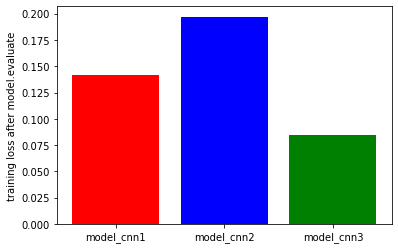

In [37]:
X = ("model_cnn1", "model_cnn2", "model_cnn3")
Y = (train_loss1, train_loss2, train_loss3)
plt.bar(X, Y, color=('r', 'b', 'g'))
plt.ylabel("training loss after model.evaluate")
plt.show()

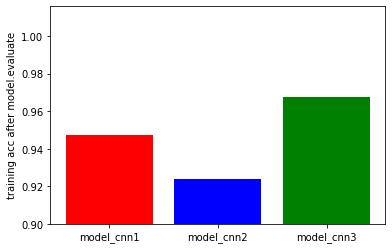

In [38]:
X = ("model_cnn1", "model_cnn2", "model_cnn3")
Y = (train_acc1, train_acc2, train_acc3)
plt.bar(X, Y, color=('r', 'b', 'g'))
plt.axis([None, None, 0.9, None])
plt.ylabel("training acc after model.evaluate")
plt.show()